<a href="https://colab.research.google.com/github/bstrain71/422_boston_housing/blob/master/Strain_Boston_Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ingest

In [0]:
# import base packages into the namespace for this program
import numpy as np
import pandas as pd
import sklearn
import math
import sklearn.model_selection
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


# read data from github
df = pd.read_csv('https://raw.githubusercontent.com/bstrain71/422_boston_housing/master/boston.csv')


# remove neighborhood column IAW instructions
df = df.drop(columns=['neighborhood'])

base_df = df # save this to call column names, etc


## EDA

In [0]:
# i would like to predict the natural log vice the actual values
df['mv'] = np.log(df['mv'])
df = pd.DataFrame(df)

print(df.shape)
df.describe()

(506, 13)


,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,3.034558
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,0.408275
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,1.609438
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,2.834680
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,3.054001
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,3.218876
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,3.912023


In [0]:
# preprocess the data - scale everything to zero mean and unit variance
# scale everything but the response variable
no_response = df.drop(columns=['mv'])
df_preprocessing = sklearn.preprocessing.scale(no_response)
df = pd.concat((pd.DataFrame(df_preprocessing),
                pd.DataFrame(df['mv'])),
               axis = 1)

df.columns = list(base_df.columns) 

df.describe()

,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
count,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,506.000000
mean,-8.688702e-17,3.306534e-16,2.804081e-16,-3.100287e-16,-8.071058e-16,-5.978968e-17,-2.650493e-16,8.293761e-17,1.514379e-15,-9.934960e-16,4.493551e-16,-1.595123e-16,3.034558
std,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,0.408275
min,-4.197819e-01,-4.877224e-01,-1.557842e+00,-2.725986e-01,-1.465882e+00,-3.880249e+00,-2.335437e+00,-1.267069e+00,-9.828429e-01,-1.313990e+00,-2.707379e+00,-1.531127e+00,1.609438
25%,-4.109696e-01,-4.877224e-01,-8.676906e-01,-2.725986e-01,-9.130288e-01,-5.686303e-01,-8.374480e-01,-8.056878e-01,-6.379618e-01,-7.675760e-01,-4.880391e-01,-7.994200e-01,2.834680
50%,-3.906665e-01,-4.877224e-01,-2.110985e-01,-2.725986e-01,-1.442174e-01,-1.084655e-01,3.173816e-01,-2.793234e-01,-5.230014e-01,-4.646726e-01,2.748590e-01,-1.812536e-01,3.054001
75%,7.396560e-03,4.877224e-02,1.015999e+00,-2.725986e-01,5.986790e-01,4.827678e-01,9.067981e-01,6.623709e-01,1.661245e+00,1.530926e+00,8.065758e-01,6.030188e-01,3.218876
max,9.933931e+00,3.804234e+00,2.422565e+00,3.668398e+00,2.732346e+00,3.555044e+00,1.117494e+00,3.960518e+00,1.661245e+00,1.798194e+00,1.638828e+00,3.548771e+00,3.912023


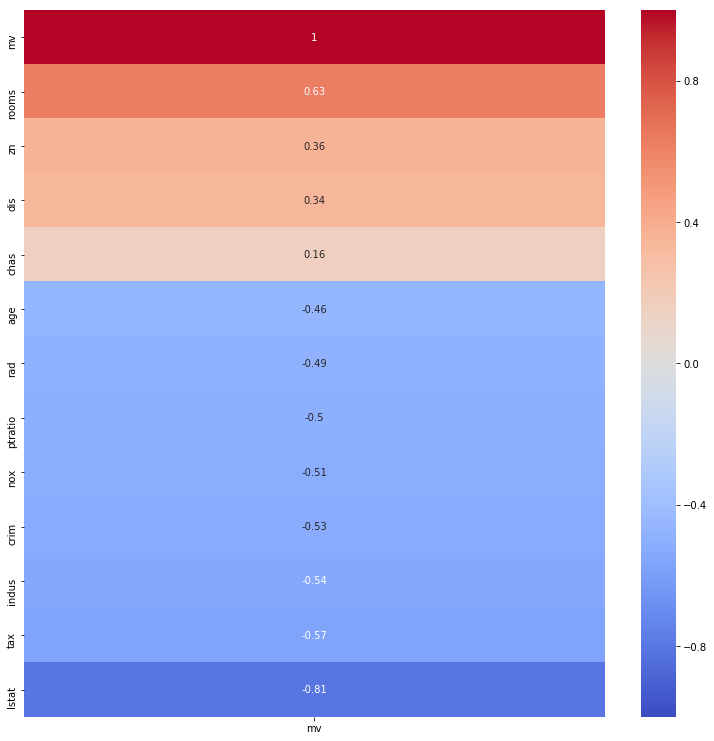

In [0]:
# correlations with mv - the response variable
# my personal cutoff is |0.4|

plt.figure(figsize=(13,13))
sns.heatmap(corr[['mv']].
            sort_values(by=['mv'],ascending=False),
            vmin=-1,
            cmap='coolwarm',
            annot=True);

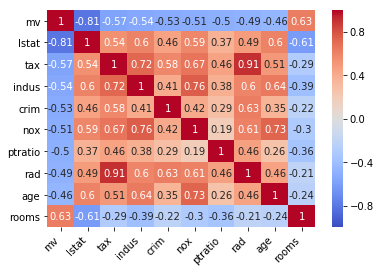

In [0]:
# correlation matrix with the top contenders for good predictive variables
mvp_corr = df[['mv','lstat','tax','indus','crim','nox','ptratio','rad','age','rooms']].corr()


ax = sns.heatmap(
    mvp_corr, 
    vmin=-1, vmax=1, center=0,
    cmap='coolwarm',
    annot=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);


The variables tax and rad are highly correlated (0.91) so only one of them should be used in the regression - OR
we can try an interaction term with them. Let's look at that in the modeling phase.

## Modeling

In [0]:
mvp_df = df[['mv','lstat','tax','indus','crim','nox',
             'ptratio','rad','age','rooms']]

mvp_df.loc[:,:].head()

,mv,lstat,tax,indus,crim,nox,ptratio,rad,age,rooms
0,3.178054,-1.075562,-0.666608,-1.287909,-0.419782,-0.144217,-1.459000,-0.982843,-0.120013,0.413672
1,3.072693,-0.492439,-0.987329,-0.593381,-0.417339,-0.740262,-0.303094,-0.867883,0.367166,0.194274
2,3.546740,-1.208727,-0.987329,-0.593381,-0.417342,-0.740262,-0.303094,-0.867883,-0.265812,1.282714
3,3.508556,-1.361517,-1.106115,-1.306878,-0.416750,-0.835284,0.113032,-0.752922,-0.809889,1.016303
4,3.589059,-1.026501,-1.106115,-1.306878,-0.412482,-0.835284,0.113032,-0.752922,-0.511180,1.228577


### Don't forget to code an interaction variable for tax and rad!!!

In [0]:
mvp_df = df[['mv','lstat','tax','indus','crim','nox',
             'ptratio','rad','age','rooms']]

X_train, X_test, y_train, y_test = train_test_split(
  mvp_df.loc[:,'lstat':], mvp_df.loc[:,'mv'],
    random_state=24601)


ridge = LinearRegression().fit(X_train, y_train)
print("Training set score: {:.3f}".format(ridge.score(X_train, y_train)))
print("Test set score: {:.3f}".format(ridge.score(X_test, y_test)))

ridge_predictions = pd.DataFrame(ridge.predict(X_test))
ridge_predictions.describe()

Training set score: 0.772
Test set score: 0.742


,0
count,127.000000
mean,3.026434
std,0.379380
min,1.985642
25%,2.772448
50%,3.068126
75%,3.321542
max,3.714624


Attempting to include an interaction variable: tax * rad: but first check to see if either of them are Nelder's "special points" (Nelder, J.A., The selection of terms in response-surface models - How strong is the weak-heredity principle? *The American Statistician*, 52, 315, 1998.)

## Conclusion